# Experiments with Hough transform

Hough transform that operates in $(k, b)$ parameter space is needed. Rectangular images are supposed to be zero-padded in the direction of smaller dimension, as it is suggested by [Brady, M.L., 1998].

In [1]:
# Necessary includes

# Pillow (for image storing)
from PIL import Image, ImageOps
# NumPy (for fast vectorised computations)
import numpy as np
# Matplotlib (for inline image rendering)
import matplotlib.pyplot as plot

In [2]:
# Experimental placeholder IM_PATH
#
# Needs to be replaced with a varibale set by end user
# in production version of the program

IM_PATH = '../sample_images/NotreDamedeReims.jpg'

## Auxiliary toolset

In [3]:
def render_image(image):
    plot.figure(figsize=(10, 10))
    plot.imshow(np.asarray(image))
    return

In [4]:
def add_padding(image, left=1, right=1, top=1, bottom=1, filler='#000000'):
    """
    Add padding to an image
    
    Padding is filled with <filler> colour.
    
    Returns padded image.
    """
    new_image = Image.new(image.mode, (left + image.size[0] + right, top + image.size[1] + bottom), filler)
    new_image.paste(image, (top, left))
    return new_image

In [5]:
def scharr(image):
    """
    Apply Scharr operator
    
    Calculates the result of convolutional operator application represented
    with a square 3x3 matrices <kernel>.
    
    Returns the result of Scharr operator application.
    """
    scharr_h = np.array([[3, 0, -3], [10, 0, -10], [3, 0, -3]])
    scharr_v = np.array([[3, 10, 3], [0, 0, 0], [-3, -10, -3]])
    #answer = Image.new('L', image.size, '#000000')
    answer = np.zeros(image.size[::-1])
    np_image = np.asarray(ImageOps.grayscale(add_padding(image)))
    for i in range(1, np_image.shape[0] - 1):
        for j in range(1, np_image.shape[1] - 1):
            match = np_image[i-1:i+2, j-1:j+2]
            answer[i - 1][j - 1] = (np.sum(scharr_h * match)**2 + np.sum(scharr_v * match)**2)**.5
    answer = np.uint8(answer / np.max(answer) * 255)
    answer = np.array([[255 if elem > 50 else 0 for elem in row] for row in answer])
    print(answer)
    return Image.fromarray(answer, mode='L')

## Step 1. Image load

We'll utilise Pillow.

In [6]:
image = Image.open(IM_PATH)

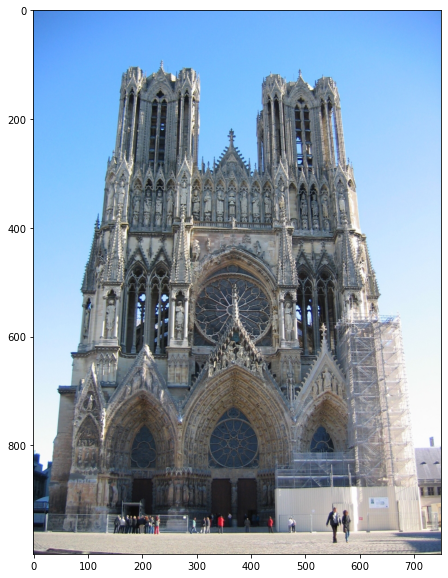

In [7]:
render_image(image)

## Step 2. Edge detection

With $3 \times 3$ Scharr operator.

In [8]:
#render_image(scharr(image))
scharr(image).show()

[[255 255 255 ... 255 255 255]
 [255   0   0 ...   0   0 255]
 [255   0   0 ...   0   0 255]
 ...
 [255   0   0 ...   0   0 255]
 [255   0   0 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
